<a href="https://colab.research.google.com/github/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/blob/main/2_Simple_encoder_decoder_Medical_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
image_folder = '/content/drive/My Drive/Medical image Reporting/Images'
df_path = '/content/drive/My Drive/Medical image Reporting/df_final.pkl'
chexnet_weights = '/content/drive/My Drive/Medical image Reporting/ChexNet weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Softmax, Embedding, LSTM,Dot,Reshape,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.compat.v1.enable_eager_execution()

# **Creating Tokenizer**

In [3]:
df = pd.read_pickle(df_path)
col = ['image_1','image_2','impression']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df.impression = '<CLS> ' + df.impression + ' <END>' 
print(df.shape)
df.head(2)

(4033, 3)


,image_1,image_2,impression
0,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,<CLS> bilateral lower lobe opacities . the app...
1,/content/drive/My Drive/Medical image Reportin...,/content/drive/My Drive/Medical image Reportin...,<CLS> bilateral lower lung airspace disease ri...


In [4]:
df = df.sample(random_state = 420,frac = 1).reset_index(drop = True) #shuffling the dataframe

#splitting to train,test with 0.9,0.1 ratio
train_size = int(0.9*df.shape[0])
train = df[:train_size]
test = df[train_size:]

del df,train_size
train.shape,test.shape

((3629, 3), (404, 3))

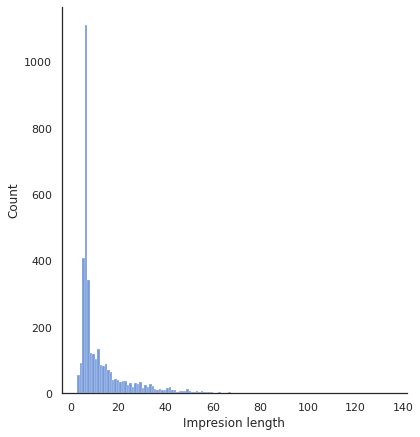


Value Counts for caption length top 5 values

Length|Counts
7     1111
6      409
8      342
12     134
9      122
dtype: int64

The max and min value of "caption length" was found to be 135 and 3 respectively
The 99.5 percentile value of caption_len which is 74 will be taken as the maximum padded value for each impression


In [32]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression.values)
train_captions = tokenizer.texts_to_sequences(train.impression) 
test_captions = tokenizer.texts_to_sequences(test.impression) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 99.5 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,99.5)))
max_pad = int(np.percentile(caption_len,99.5))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader

# **Creating an input data pipeline**

# CHeXNET Model (pretrained)

[CheXNET Model](https://arxiv.org/pdf/1711.05225.pdf) is a Denset121 layered model which is trained on 1000s of chest x-ray images for the classification of 14 diseases.We can load the weights of that model and pass the image through that model.

In [34]:
def create_chexnet(chexnet_weights = chexnet_weights):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  return chexnet

In [35]:
chexnet = create_chexnet()
chexnet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

(420, 512, 3)

In [43]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically

    # https://imgaug.readthedocs.io/en/latest/source/overview/convolutional.html?highlight=emboss#emboss
    self.aug3 = iaa.Emboss(alpha=(1), strength=1) #embosses image

    #https://imgaug.readthedocs.io/en/latest/source/api_augmenters_convolutional.html?highlight=sharpen#imgaug.augmenters.convolutional.Sharpen
    self.aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5)) #sharpens the image and apply some lightness/brighteness 1 means fully sharpened etc

  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image to  and apply augmentation
    #from image segmentation assignment
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)

    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]]
    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post')

    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    aug1 = iaa.Fliplr(1) #flip images horizaontally
    aug2 = iaa.Flipud(1) #flip images vertically

    # https://imgaug.readthedocs.io/en/latest/source/overview/convolutional.html?highlight=emboss#emboss
    aug3 = iaa.Emboss(alpha=(1), strength=1) #embosses image

    #https://imgaug.readthedocs.io/en/latest/source/api_augmenters_convolutional.html?highlight=sharpen#imgaug.augmenters.convolutional.Sharpen
    aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5)) #sharpens the image and apply some lightness/brighteness 1 means fully sharpened etc

    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.2:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.4:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          elif a<0.6:
              image1 = self.aug3.augment_image(image1)
              image2 = self.aug3.augment_image(image2)
          elif a<0.8:
              image1 = self.aug4.augment_image(image1)
              image2 = self.aug4.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption

    
  def __len__(self):
    return len(self.image1)


class Dataloder(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset[0]))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = [dataset[j] for j in range(start,stop)] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] # image,mask  here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3,batch_size*1*max_pad

        
        return tuple(batch) #shape = batch_size*input_size(of image)*3,batch_size*input_size(of image)*3,batch_size*1*max_pad
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

3

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.690719 to fit



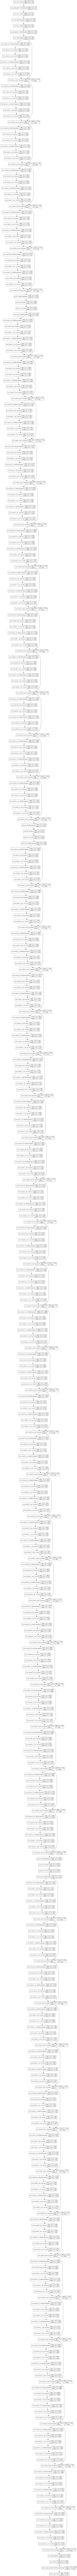

In [ ]:
tf.keras.utils.plot_model(
    chexnet,
    to_file="model_1.png",
    show_shapes=True,

)
